# Librerias

In [ ]:
from google.colab import drive
import seaborn as sns
import sklearn.metrics as metrics
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
from PIL import Image
import pickle
import collections
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras.models import Model
from scipy.optimize import minimize 
from sklearn.metrics import log_loss
from funciones_auxiliares import *

# Importamos data

In [ ]:
# cambiar path
path="/content/gdrive/MyDrive/modelosFER2013"

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
data=pd.read_csv("/content/gdrive/MyDrive/fer2013.csv")
Emotions = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

In [ ]:
# Separamos training y public/private testing data
valid_data = data[data.Usage=="PublicTest"].reset_index(drop=True)
test_data = data[data.Usage=="PrivateTest"].reset_index(drop=True)
train_data = data[data.Usage=="Training"].reset_index(drop=True)

# Loading

In [ ]:
fer2013_to_X(train_data,"train")
fer2013_to_X(valid_data,"valid")
fer2013_to_X(test_data,"test")

# Modelos

https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/leaderboard

In [ ]:
modelo_logistico=pickle.load(open(f"{path}/ML_final_model.sav", 'rb'))
modelo_fc=tf.keras.models.load_model(f"{path}/FC_final_model.h5")
modelo_cnn=tf.keras.models.load_model(f"{path}/CNN_final_model.h5")
modelo_tl=tf.keras.models.load_model(f"{path}/VGGface_final_model.h5")

In [ ]:
img_height, img_width, img_channel = 48,48,1
xy_testing = tf.keras.preprocessing.image_dataset_from_directory("/content/data/test", image_size=(48,48), color_mode='grayscale',label_mode="int")

Found 3589 files belonging to 7 classes.


In [ ]:
x_test=[]
y_test=[]
for x, y in xy_testing:
  for im in list(np.array(x)):
    x_test=x_test+[np.array(im)]#a)]
  y_test=y_test+list(np.array(y))

x_test=np.array(x_test).reshape(len(x_test), img_height, img_width, img_channel)
y_test=np.array(y_test)

In [ ]:
img_height, img_width, img_channel = 224, 224,3
xy_testing_rgb = tf.keras.preprocessing.image_dataset_from_directory("/content/data/test", image_size=(img_height, img_width), color_mode='rgb',label_mode="int")

Found 3589 files belonging to 7 classes.


In [ ]:
x_test_rgb=[]
y_test_rgb=[]

for x, y in xy_testing_rgb:
  for im in list(np.array(x)):
    x_test_rgb=x_test_rgb+[np.array(im)]#a)]
  y_test_rgb=y_test_rgb+list(np.array(y))

x_test_rgb=np.array(x_test_rgb).reshape(len(x_test_rgb), img_height, img_width, img_channel)
y_test_rgb=np.array(y_test_rgb)

In [ ]:
img_height, img_width, img_channel = 48,48,1
xy_validation = tf.keras.preprocessing.image_dataset_from_directory("/content/data/valid", image_size=(48,48), color_mode='grayscale',label_mode="int")

Found 3589 files belonging to 7 classes.


In [ ]:
x_valid=[]
y_valid=[]
for x, y in xy_validation:
  for im in list(np.array(x)):
    x_valid=x_valid+[np.array(im)]#a)]
  y_valid=y_valid+list(np.array(y))

x_valid=np.array(x_valid).reshape(len(x_valid), img_height, img_width, img_channel)
y_valid=np.array(y_valid)

# Metricas matrices de confusion




### Regresión Logística

In [ ]:
y_pred=modelo_logistico.predict(x_test.reshape(len(x_test), 48*48*1))
np.mean(y_pred==y_test)

In [ ]:
plot_cm(y_test, y_pred)

### Red Fully Connected

In [ ]:
test_loss, test_acc = modelo_fc.evaluate(xy_testing, verbose=2)
test_loss, test_acc

In [ ]:
y_pred=modelo_fc.predict(x_test).argmax(axis=1)
plot_cm(y_test, y_pred)

### Red CNN

In [ ]:
test_loss, test_acc = modelo_cnn.evaluate(xy_testing, verbose=2)
test_loss, test_acc

In [ ]:
y_pred=modelo_cnn.predict(x_test).argmax(axis=1)
plot_cm(y_test, y_pred)

### Redes preentrenadas

In [ ]:
test_loss, test_acc = modelo_tl.evaluate(xy_testing_rgb, verbose=2)
test_loss, test_acc

In [ ]:
y_pred=modelo_tl.predict(x_test_rgb).argmax(axis=1)
plot_cm(y_test_rgb, y_pred)

# Reliability diagrams

Funciones: https://github.com/markus93/NN_calibration/blob/master/scripts/calibration/Reliability%20Diagram.ipynb

In [ ]:
y_test_rgb
y_pred_tl=modelo_tl.predict(x_test_rgb).argmax(axis=1)
y_confs_tl=modelo_tl.predict(x_test_rgb).max(axis=1)
y_probs_tl=modelo_tl.predict(x_test_rgb)
acc_tl,conf_tl,lon=get_bin_info(y_confs_tl, y_pred_tl, y_test_rgb, bin_size = 0.1)

In [ ]:
acc_tl,conf_tl

([0, 0, 0, 0, 0, 0, 0, 0.0, 0.42857142857142855, 0.7215861491203575],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0.7476551532745361,
  0.8539195571626935,
  0.9970579720415639])

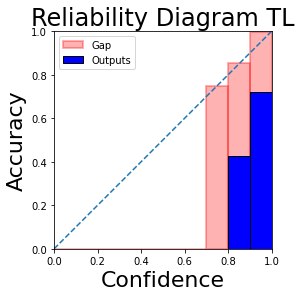

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex='col', sharey='row')
rel_diagram_sub(acc_tl,conf_tl, ax, name = "Reliability Diagram TL",  yname = "Accuracy", xname="Confidence")

In [ ]:
y_test
y_pred=modelo_cnn.predict(x_test).argmax(axis=1)
y_confs=modelo_cnn.predict(x_test).max(axis=1)
y_probs=modelo_cnn.predict(x_test)
acc,conf,lon=get_bin_info(y_confs, y_pred, y_test, bin_size = 0.1)

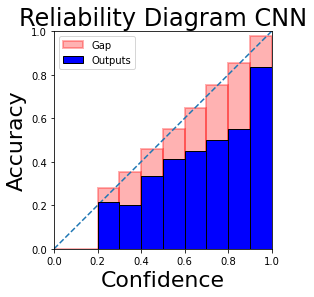

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex='col', sharey='row')
rel_diagram_sub(acc, conf, ax, name = "Reliability Diagram CNN", yname = "Accuracy", xname="Confidence")

# Calibrando CNN

https://stackoverflow.com/questions/62013025/keras-remove-activation-function-of-last-layer

In [ ]:
# Hold weights:
weights = modelo_cnn.get_weights()

# Model - softmax
modelo_cnn_no_softmax = keras.Sequential([
    keras.layers.InputLayer(input_shape=(48,48,1)),
    keras.models.Sequential(modelo_cnn.layers[:-1]),
    keras.layers.Dense(7, name='dense_51')
])

# 4. Pass the imagenet weights onto the second resnet
modelo_cnn_no_softmax.set_weights(modelo_cnn.get_weights())

In [ ]:
y_logits_val=modelo_cnn_no_softmax.predict(x_valid)
y_logits_test=modelo_cnn_no_softmax.predict(x_test)

y_probs_val=modelo_cnn.predict(x_valid)
y_probs_test=modelo_cnn.predict(x_test)

In [ ]:
true = y_valid.flatten() # Flatten y_val

In [ ]:
opt = minimize(loss_fun, x0 = 1, args=(y_logits_val, true))
T= opt.x[0]

In [ ]:
y_probs_ts=[softmax(probs/T) for probs in y_logits_test]
y_confs_ts=np.array(y_probs_ts).max(axis=1)
y_pred_ts=np.array(y_probs_ts).argmax(axis=1)

acc_ts,conf_ts,lon=get_bin_info(y_confs_ts, y_pred_ts, y_test, bin_size = 0.1)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex='col', sharey='row')
rel_diagram_sub(acc_ts,conf_ts, ax, name = "Reliability Diagram CNN calibrada", yname = "Accuracy", xname="Confidence")

# Exploración expresiones

In [ ]:
expresiones=x_test[y_test==1]
print(expresiones.shape)
#Data Visualization using matplotlib
fig = plt.figure(figsize=(6,8))
for i in range(1, 10):
    fig.add_subplot(3,3,i)
    plt.imshow(expresiones[i].reshape(48,48),cmap='gray')
    plt.grid(False)

In [ ]:
modelo=modelo_cnn
for layer in modelo.layers:
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue
	# get filter weights
	filters, biases = layer.get_weights()
	print(layer.name, filters.shape)


num=1
# redefine model to output right after the first hidden layer
model = Model(inputs=modelo.inputs, outputs=modelo.layers[num].output)
model.summary()

# load the image with the required shape
img = expresiones[4]

# expand dimensions so that it represents a single 'sample'
img = np.expand_dims(img, axis=0)
print(img.shape)
# get feature map for first hidden layer
feature_maps = model.predict(img)

# plot all 64 maps in an 8x8 squares
square = 3
ix = 1
for _ in range(square):
  for _ in range(square):
    # specify subplot and turn of axis
    ax = plt.subplot(square, square, ix)
    ax.set_xticks([])
    ax.set_yticks([])
		# plot filter channel in grayscale
    plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
    ix += 1
    
# show the figure
plt.show()